In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

import xgboost as xgb

In [2]:
train_df = pd.read_csv('/DataScience/liverpool-ion-switching/train.csv')
test_df = pd.read_csv('/DataScience/liverpool-ion-switching/test.csv')

In [3]:
train_df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
train_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
time             5000000 non-null float64
signal           5000000 non-null float64
open_channels    5000000 non-null int64
dtypes: float64(2), int64(1)
memory usage: 114.4 MB


In [5]:
test_df.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [6]:
test_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 2 columns):
time      2000000 non-null float64
signal    2000000 non-null float64
dtypes: float64(2)
memory usage: 30.5 MB


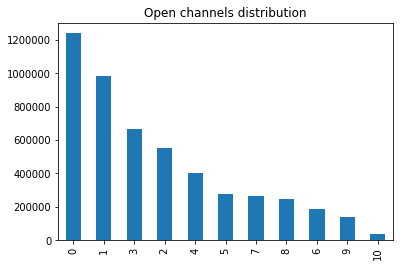

In [15]:
train_df['open_channels'].value_counts().plot(kind='bar')
plt.title('Open channels distribution')
plt.show()

The open_channels target is not evenly distributed, look like it decreases almost linearly.

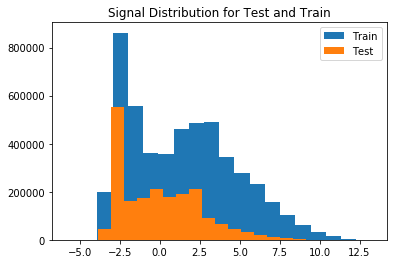

Train mean 1.3862463138400012, median 1.124, standard deviation 3.336219014038231
Test mean -0.04259113839998026, median -0.3551, standard deviation 2.5051191008809552

Train: NormaltestResult(statistic=334360.8615541461, pvalue=0.0)
Test: NormaltestResult(statistic=334360.8615541461, pvalue=0.0)


In [8]:
plt.hist(train_df.signal, bins=20)
plt.hist(test_df.signal, bins=20)
plt.title('Signal Distribution for Test and Train')
plt.legend(labels=['Train', 'Test'])
plt.show()
print('Train mean {}, median {}, standard deviation {}'.format(np.mean(train_df.signal), np.median(train_df.signal), np.std(train_df.signal)))
print('Test mean {}, median {}, standard deviation {}'.format(np.mean(test_df.signal), np.median(test_df.signal), np.std(test_df.signal)))
print('\nTrain:', stats.normaltest(train_df.signal))
print('Test:', stats.normaltest(train_df.signal))

Distribution of the signal feature for the train and test data. They appear to have similar distributions, but the mean, median, and standard deviations are all different. Even though they are not normally distributed, both distributions have enough samples to make a t-test valid.

In [9]:
stats.ttest_ind(train_df.signal, test_df.signal)

Ttest_indResult(statistic=547.117906304146, pvalue=0.0)

Despite the similar shape, these definitely were NOT both randomly sampled from the same population.

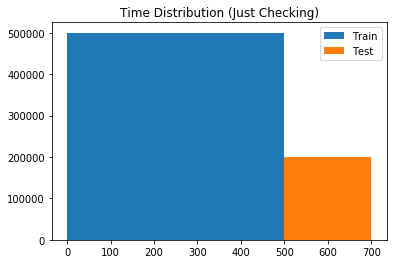

In [10]:
plt.hist(train_df.time)
plt.hist(test_df.time)
plt.legend(labels=['Train', 'Test'])
plt.title('Time Distribution (Just Checking)')
plt.show()

The time feature resets every 50. Thank you https://www.kaggle.com/artgor/eda-and-model-qwk-optimization for the following little batch code:

In [11]:
train_df['batch'] = 0
for i in range(0, 10):
    train_df.iloc[i * 500000: 500000 * (i + 1), 3] = i

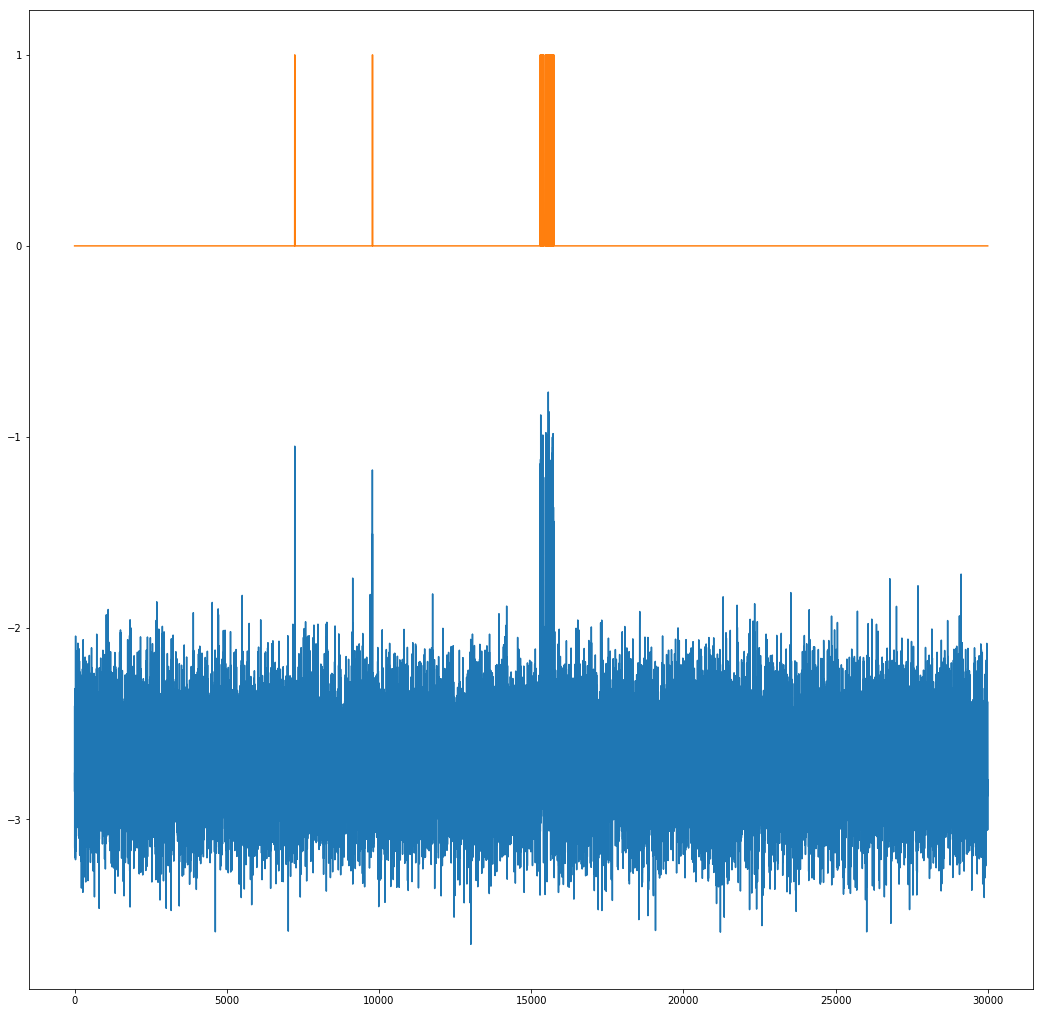

In [12]:
plt.figure(figsize=(18,18))
plt.plot(train_df.signal[train_df.time < 3])
plt.plot(train_df.open_channels[train_df.time < 3])
plt.show()

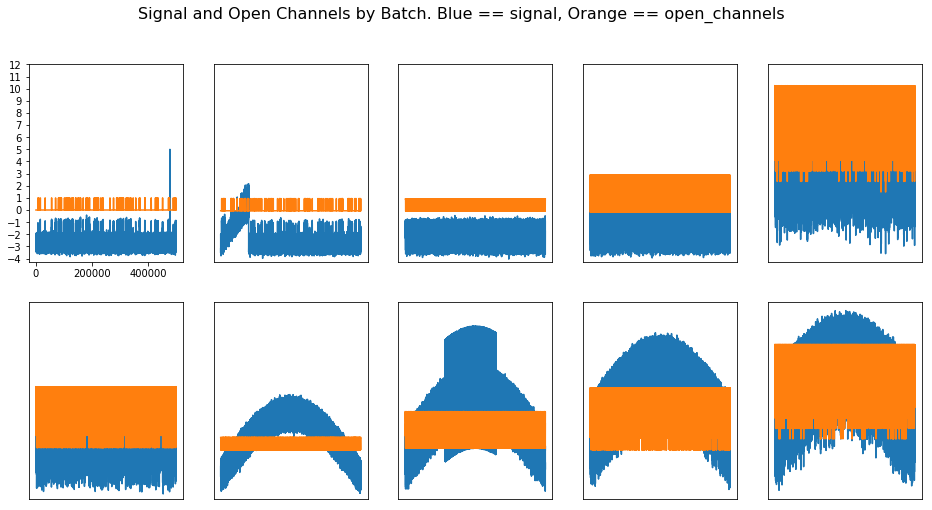

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
num_batches = len(train_df.batch.unique())
fig.suptitle('Signal and Open Channels by Batch. Blue == signal, Orange == open_channels', fontsize=16)
axis_on = True
for i in range(num_batches):
    axes[i // (num_batches // 2), i % (num_batches // 2)].plot(train_df.signal[train_df.batch == i])
    axes[i // (num_batches // 2), i % (num_batches // 2)].plot(train_df.open_channels[train_df.batch == i])
    axes[i // (num_batches // 2), i % (num_batches // 2)].set_yticks(range(-4, 13))
    if axis_on == False:
        axes[i // (num_batches // 2), i % (num_batches // 2)].set_xticks([])
        axes[i // (num_batches // 2), i % (num_batches // 2)].set_yticks([])
    axis_on = False

In [16]:
test_df['batch'] = 0
for i in range(0, 4):
    test_df.iloc[i * 500000: 500000 * (i + 1), 2] = i

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
num_batches = len(test_df.batch.unique())
fig.suptitle('Test Distributions', fontsize=16)
axis_on = True
for i in range(num_batches):
    axes[i // (num_batches // 2), i % (num_batches // 2)].plot(test_df.signal[test_df.batch == i])
    axes[i // (num_batches // 2), i % (num_batches // 2)].set_yticks(range(-4, 13))
    if axis_on == False:
        axes[i // (num_batches // 2), i % (num_batches // 2)].set_xticks([])
        axes[i // (num_batches // 2), i % (num_batches // 2)].set_yticks([])
    axis_on = False

NameError: name 'test_df' is not defined

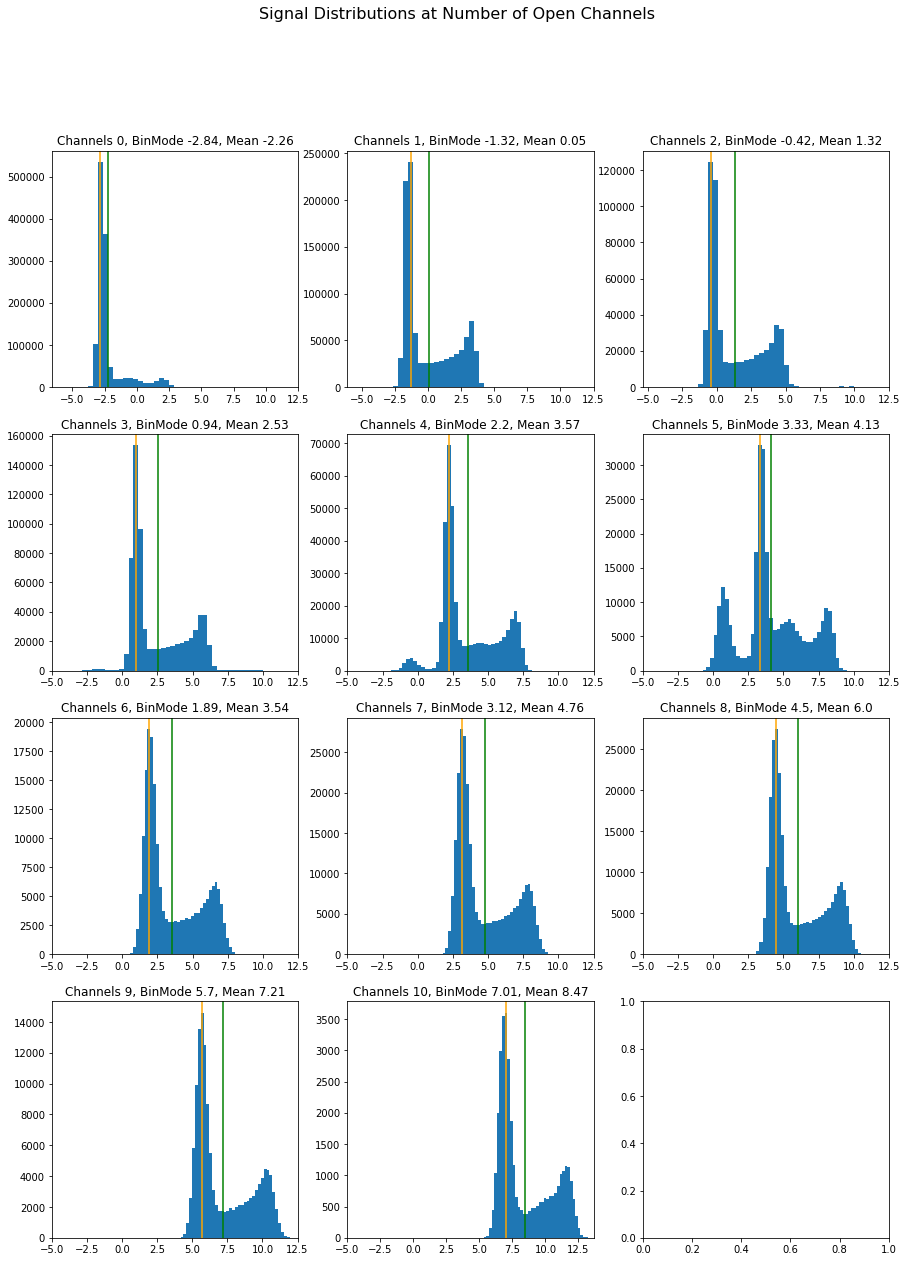

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Signal Distributions at Number of Open Channels', fontsize=16)
for i in range(11):
    n, bins, patches = axes[i // 3, i % 3].hist(train_df.signal[train_df.open_channels == i], bins=40)
    ind = list(n).index(max(n))
    mean = round(np.mean(train_df.signal[train_df.open_channels == i]), 2)
    binned_mode = (bins[ind] + bins[ind + 1])/2
    axes[i // 3, i % 3].set_title('Channels {}, BinMode {}, Mean {}'.format(i, round(binned_mode, 2), mean))
    axes[i // 3, i % 3].set_xticks([-5, -2.5, 0, 2.5, 5, 7.5, 10, 12.5])
    axes[i // 3, i % 3].axvline(binned_mode , color='orange')
    axes[i // 3, i % 3].axvline(mean , color='green')
plt.show()

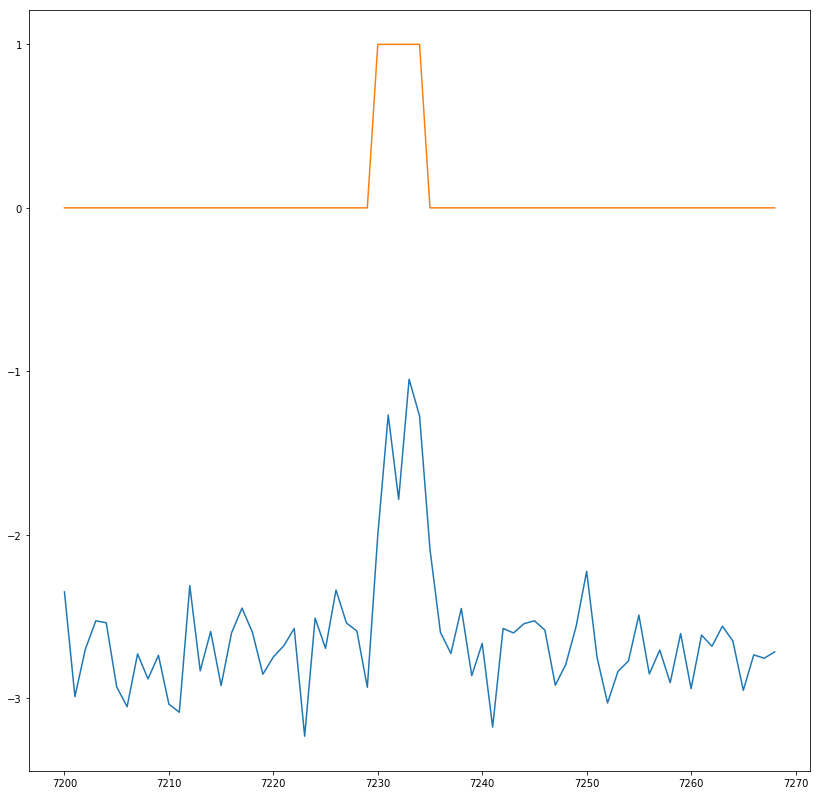

In [15]:
start = 0.72
end = 0.727
plt.figure(figsize=(14,14))
plt.plot(train_df.signal[(train_df.time > start) & (train_df.time < end)])
plt.plot(train_df.open_channels[(train_df.time > start) & (train_df.time < end)])
plt.show()

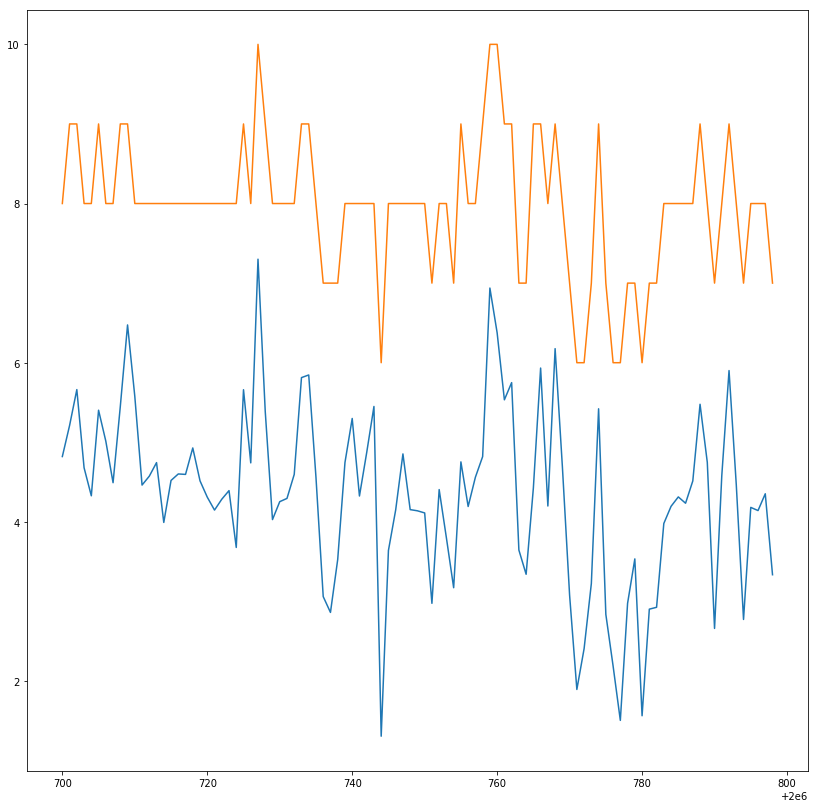

In [16]:
start = 200.07
end = 200.08
plt.figure(figsize=(14,14))
plt.plot(train_df.signal[(train_df.time > start) & (train_df.time < end)])
plt.plot(train_df.open_channels[(train_df.time > start) & (train_df.time < end)])
plt.show()

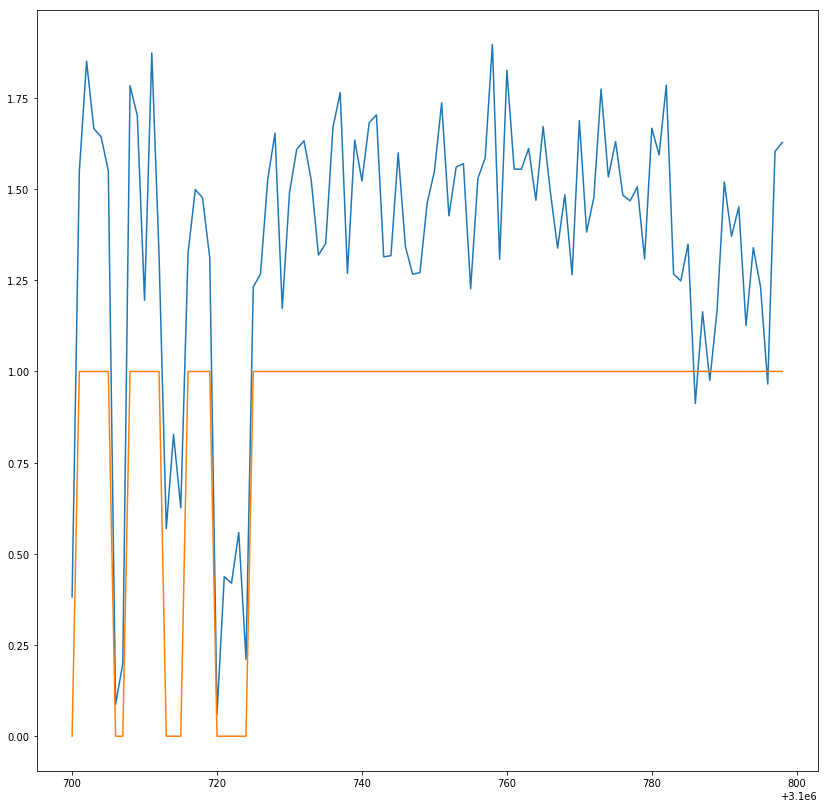

In [17]:
start = 310.07
end = 310.08
plt.figure(figsize=(14,14))
plt.plot(train_df.signal[(train_df.time > start) & (train_df.time < end)])
plt.plot(train_df.open_channels[(train_df.time > start) & (train_df.time < end)])
plt.show()

In [25]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
X = train_df[['signal', 'time']]
Y = train_df['open_channels']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
print('Results with all features:', cohen_kappa_score(preds, y_test, weights='quadratic'))

Results with all features: 0.9001290647584463


<h3>Feature Engineering</h3>

1. previous: Difference between signal and previous time increment. At the start of a chunk, just sets it to 0.
2. second: Same but two time increments ago.
3. third: three increments ago.
4. MicroMean: mean signal of very closeby neighbors
5. LocalMean: mean signal of semi-closeby neighbors
6. MacroMean: mean signal in a large range

In [18]:
previous_signal = []
for batch in train_df.batch.unique():
    previous_signal += [train_df[train_df.batch == batch].signal.iloc[0]]
    previous_signal += list(train_df[train_df.batch == batch].signal.iloc[:-1])
train_df['previous'] = previous_signal
train_df['previous'] = train_df.previous - train_df.signal

previous_signal = []
for batch in test_df.batch.unique():
    previous_signal += [test_df[test_df.batch == batch].signal.iloc[0]]
    previous_signal += list(test_df[test_df.batch == batch].signal.iloc[:-1])
test_df['previous'] = previous_signal
test_df['previous'] = test_df.previous - test_df.signal

In [19]:
second_prev = []
for batch in train_df.batch.unique():
    second_prev += list(train_df[train_df.batch == batch].signal.iloc[:2])
    second_prev += list(train_df[train_df.batch == batch].signal.iloc[:-2])
train_df['second'] = second_prev
train_df['second'] = train_df.second - train_df.signal

second_prev = []
for batch in test_df.batch.unique():
    second_prev += list(test_df[test_df.batch == batch].signal.iloc[:2])
    second_prev += list(test_df[test_df.batch == batch].signal.iloc[:-2])
test_df['second'] = second_prev
test_df['second'] = test_df.second - test_df.signal

In [20]:
third_prev = []
for batch in train_df.batch.unique():
    third_prev += list(train_df[train_df.batch == batch].signal.iloc[:3])
    third_prev += list(train_df[train_df.batch == batch].signal.iloc[:-3])
train_df['third'] = third_prev
train_df['third'] = train_df.third - train_df.signal

third_prev = []
for batch in test_df.batch.unique():
    third_prev += list(test_df[test_df.batch == batch].signal.iloc[:3])
    third_prev += list(test_df[test_df.batch == batch].signal.iloc[:-3])
test_df['third'] = third_prev
test_df['third'] = test_df.third - test_df.signal

In [21]:
chunk_size = 20
batch_size = len(train_df[train_df.batch == 0])
mean_chunks = []
if batch_size // chunk_size == batch_size / chunk_size:
    for i in range(len(train_df) // chunk_size):
        mean_chunks += [np.mean(train_df.signal.iloc[chunk_size * i : chunk_size * (i + 1)])] * chunk_size
else:
    print('Error! Not an even split!')
train_df['MicroMean'] = mean_chunks

batch_size = len(test_df[test_df.batch == 0])
mean_chunks = []
if batch_size // chunk_size == batch_size / chunk_size:
    for i in range(len(test_df) // chunk_size):
        mean_chunks += [np.mean(test_df.signal.iloc[chunk_size * i : chunk_size * (i + 1)])] * chunk_size
else:
    print('Error! Not an even split!')
test_df['MicroMean'] = mean_chunks

In [22]:
chunk_size = 500
batch_size = len(train_df[train_df.batch == 0])
mean_chunks = []
if batch_size // chunk_size == batch_size / chunk_size:
    for i in range(len(train_df) // chunk_size):
        mean_chunks += [np.mean(train_df.signal.iloc[chunk_size * i : chunk_size * (i + 1)])] * chunk_size
else:
    print('Error! Not an even split!')
train_df['LocalMean'] = mean_chunks

batch_size = len(test_df[test_df.batch == 0])
mean_chunks = []
if batch_size // chunk_size == batch_size / chunk_size:
    for i in range(len(test_df) // chunk_size):
        mean_chunks += [np.mean(test_df.signal.iloc[chunk_size * i : chunk_size * (i + 1)])] * chunk_size
else:
    print('Error! Not an even split!')
test_df['LocalMean'] = mean_chunks

In [23]:
chunk_size = 5000
batch_size = len(train_df[train_df.batch == 0])
mean_chunks = []
if batch_size // chunk_size == batch_size / chunk_size:
    for i in range(len(train_df) // chunk_size):
        mean_chunks += [np.mean(train_df.signal.iloc[chunk_size * i : chunk_size * (i + 1)])] * chunk_size
else:
    print('Error! Not an even split!')
train_df['MacroMean'] = mean_chunks

batch_size = len(test_df[test_df.batch == 0])
mean_chunks = []
if batch_size // chunk_size == batch_size / chunk_size:
    for i in range(len(test_df) // chunk_size):
        mean_chunks += [np.mean(test_df.signal.iloc[chunk_size * i : chunk_size * (i + 1)])] * chunk_size
else:
    print('Error! Not an even split!')
test_df['MacroMean'] = mean_chunks

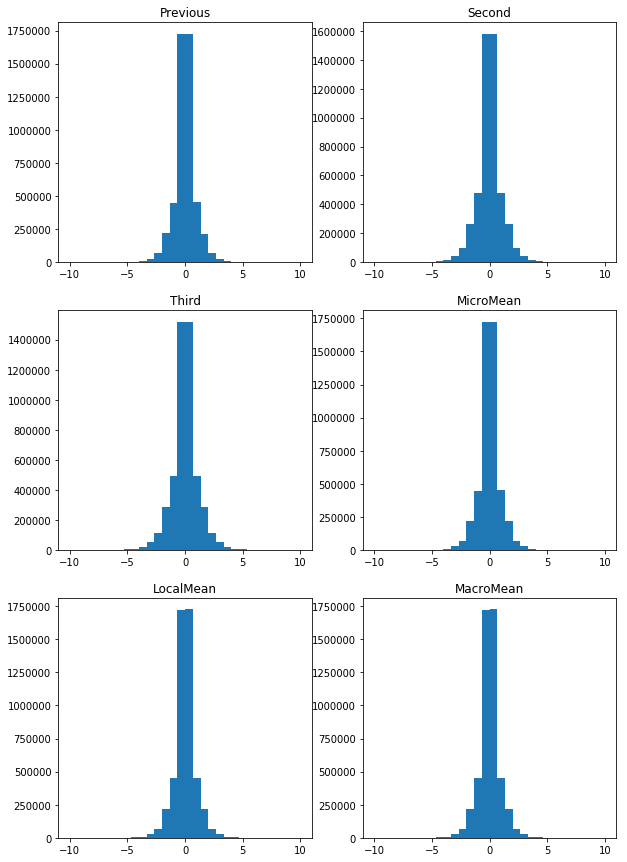

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes[0, 0].hist(train_df.previous, bins=30)
axes[0, 0].set_title('Previous')
axes[0, 1].hist(train_df.second, bins=30)
axes[0, 1].set_title('Second')
axes[1, 0].hist(train_df.third, bins=30)
axes[1, 0].set_title('Third')
axes[1, 1].hist(train_df.previous, bins=30)
axes[1, 1].set_title('MicroMean')
axes[2, 0].hist(train_df.previous, bins=30)
axes[2, 0].set_title('LocalMean')
axes[2, 1].hist(train_df.previous, bins=30)
axes[2, 1].set_title('MacroMean')
plt.show()

In [ ]:
def plot_features(col_names, start, stop, title, lw):
    plt.figure(figsize=(20,10))
    for col in range(len(col_names)):
        plt.plot(train_df[col_names[col]].iloc[start:stop], lw=lw[col])
    plt.legend(col_names, fontsize=16)
    plt.title(title, fontsize=20)
    plt.show()

In [23]:
plot_features(['signal', 'previous', 'open_channels'],
                     0, 500000, 'Previous in Batch 0', [1,1,1])

NameError: name 'plot_features' is not defined

In [ ]:
plot_features(['signal', 'previous', 'open_channels'],
                     7215, 7250, '\"Previous\" Close Up on a Bump', [3,3,3])

In [ ]:
plot_features(['signal', 'second', 'open_channels'],
                     7215, 7250, '\"Second\" Close Up on a Bump', [3,3,3])

In [ ]:
plot_features(['signal', 'third', 'open_channels'],
                     7215, 7250, '\"Third\" Close Up on a Bump', [3,3,3])

In [ ]:
plot_features(['signal', 'MicroMean'],
                     0, 500000, 'Signal and MicroMean in Batch 0', [1, 1])

In [ ]:
plot_features(['signal', 'LocalMean'],
                     0, 500000, 'Signal and LocalMean in Batch 0', [1, 5])

In [ ]:
plot_features(['signal', 'MicroMean'],
                     0, 20000, 'MicroMean Zoomed In', [1, 1])

In [ ]:
plot_features(['signal', 'MicroMean', 'Open Channels'],
                     14500, 16500, 'Zoomed Into a Hump With Open Channels', [1, 5, 1])

In [ ]:
plot_features(['signal', 'LocalMean', 'Open Channels'],
                     14500, 16500, 'LocalMean Zoomed Into a Hump With Open Channels', [1, 5, 1])

In [123]:
results = []
for batch in range(10):
    batch_results = []
    rfc = RandomForestClassifier(n_estimators=100, max_depth=4)
    X = train_df.drop(['open_channels', 'time', 'batch'], 1)[train_df.batch == batch]
    Y = train_df['open_channels'][train_df.batch == batch]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
    rfc.fit(X_train, y_train)
    
    for feature in zip(X.columns, rfc.feature_importances_):
        batch_results.append(feature[1])
    
    preds = rfc.predict(X_test)
    batch_results.append(cohen_kappa_score(preds, y_test, weights='quadratic'))
    results.append(batch_results)
    
results_df = pd.DataFrame()
results_df['Signal'] = [item[0] for item in results]
results_df['Previous'] = [item[1] for item in results]
results_df['Second'] = [item[2] for item in results]
results_df['Third'] = [item[3] for item in results]
results_df['MicroMean'] = [item[4] for item in results]
results_df['LocalMean'] = [item[5] for item in results]
results_df['MacroMean'] = [item[6] for item in results]
results_df['Kappa'] = [item[7] for item in results]

In [128]:
results_df

,Signal,Previous,Second,Third,MicroMean,LocalMean,MacroMean,Kappa
0,0.549061,0.020407,0.030633,0.061854,0.263959,0.070632,0.003453,0.991018
1,0.181591,0.034435,0.099704,0.174703,0.110920,0.134971,0.263677,0.887286
2,0.653736,0.026354,0.065743,0.065200,0.169622,0.019342,0.000004,0.990661
3,0.663803,0.020310,0.042300,0.063834,0.192245,0.017496,0.000012,0.968341
4,0.731696,0.011920,0.027169,0.044404,0.173140,0.011612,0.000059,0.930018
5,0.730874,0.015245,0.036497,0.048381,0.156972,0.011849,0.000182,0.964621
6,0.195057,0.076178,0.184129,0.353096,0.055210,0.049588,0.086742,0.640588
7,0.474683,0.035814,0.101712,0.160652,0.112073,0.049181,0.065885,0.554015
8,0.488830,0.044251,0.081221,0.128739,0.121568,0.058005,0.077387,0.670705
9,0.542216,0.024948,0.055095,0.104404,0.140232,0.046021,0.087084,0.706889


In [ ]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
X = train_df[['signal', 'previous', 'second', 'third', 'MicroMean', 'LocalMean', 'MacroMean']]
Y = train_df['open_channels']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
print('Results with original features:', cohen_kappa_score(preds, y_test, weights='quadratic'))

Large increase in kappa score with these features.

<h3>Analysis of Feature Engineering pt. 1</h3>

In the previous section I engineered 6 features: The past 3 signal datapoints, and then the localized mean at 3 different window sizes.

Since this is time series data, and from looking at the signal plot it appeared that past datapoints affect the open_channels target variable. The localized means acts as a 'smoothing' for the data as well, which might add insight since the data is subject to quite a bit of random noise. I modeled each chunk of the data seperately using Random Forest and then used the feature importances attribute in scikit-learn.

'Previous', 'Second', and 'Third' were all very low importance for 'flat' shapes of the signal. However, in curved or sloped batches, they increase in importance, with Third being the most important followed by Second and then Previous. In batch 6, Third is a more important feature than signal, which is pretty amazing. Based on this, I want to add features beyond the Third last datapoint. I will have to manage the size of my data however.

The three localized mean features were also somewhat important. MicroMean is very important in the batch 0, which is not surprising since it just acts as a very localized smoothing feature. In the second batch, all three were important features with MacroMean helping the most. Maybe it was most helpful because of the chaotic start of the data. Interestingly, MacroMean is extremely unimportant for batches 2 - 5

<h2>Feature Engineering pt. 2</h2>
    
1. PreviousAverage
2. FutureAverage
3. LocalSlope
4. MacroPreviousAverage
5. MacroFutureAverage
6. MacroSlope
7. BigMacroPreviousAverage
8. BigMacroFutureAverage
9. BigMacroSlope

In [208]:
avg = []
win_size = 100
cs = 500000 #chunk size
for i in range(len(train_df)):
    if (i % cs) - win_size <= 0:
        avg.append(np.mean(train_df.signal.iloc[(i//cs) * cs : ((i//cs) * cs) + win_size]))
    else:
        avg.append(np.mean(train_df.signal.iloc[i - win_size : i]))
train_df['PrevAvgLittle'] = avg

avg = []
for i in range(len(train_df)):
    if (i % cs) > cs - win_size:
        avg.append(np.mean(train_df.signal.iloc[((i//cs + 1) * cs) - win_size : (i//cs + 1) * cs]))
    else:
        avg.append(np.mean(train_df.signal.iloc[i : i + win_size]))
train_df['FutAvgLittle'] = avg
                                
train_df['SlopeLittle'] = train_df['FutAvgLittle'] - train_df['PrevAvgLittle']

train_df['PrevAvgLittle'].fillna(method='bfill', inplace=True)
train_df['FutAvgLittle'].fillna(method='ffill', inplace=True)
train_df['SlopeLittle'].fillna(method='bfill', inplace=True)
train_df['SlopeLittle'].fillna(method='ffill', inplace=True)

In [209]:
avg = []
win_size = 1000
cs = 500000 #chunk size
for i in range(len(train_df)):
    if (i % cs) - win_size <= 0:
        avg.append(np.mean(train_df.signal.iloc[(i//cs) * cs : ((i//cs) * cs) + win_size]))
    else:
        avg.append(np.mean(train_df.signal.iloc[i - win_size : i]))
train_df['PrevAvgMedium'] = avg

avg = []
for i in range(len(train_df)):
    if (i % cs) > cs - win_size:
        avg.append(np.mean(train_df.signal.iloc[((i//cs + 1) * cs) - win_size : (i//cs + 1) * cs]))
    else:
        avg.append(np.mean(train_df.signal.iloc[i : i + win_size]))
train_df['FutAvgMedium'] = avg
                                
train_df['SlopeMedium'] = train_df['FutAvgMedium'] - train_df['PrevAvgMedium']

train_df['PrevAvgMedium'].fillna(method='bfill', inplace=True)
train_df['FutAvgMedium'].fillna(method='ffill', inplace=True)
train_df['SlopeMedium'].fillna(method='bfill', inplace=True)
train_df['SlopeMedium'].fillna(method='ffill', inplace=True)

In [210]:
avg = []
win_size = 5000
cs = 500000 #chunk size
for i in range(len(train_df)):
    if (i % cs) - win_size <= 0:
        avg.append(np.mean(train_df.signal.iloc[(i//cs) * cs : ((i//cs) * cs) + win_size]))
    else:
        avg.append(np.mean(train_df.signal.iloc[i - win_size : i]))
train_df['PrevAvgBig'] = avg

avg = []
for i in range(len(train_df)):
    if (i % cs) > cs - win_size:
        avg.append(np.mean(train_df.signal.iloc[((i//cs + 1) * cs) - win_size : (i//cs + 1) * cs]))
    else:
        avg.append(np.mean(train_df.signal.iloc[i : i + win_size]))
train_df['FutAvgBig'] = avg
                                
train_df['SlopeBig'] = train_df['FutAvgBig'] - train_df['PrevAvgBig']

train_df['PrevAvgBig'].fillna(method='bfill', inplace=True)
train_df['FutAvgBig'].fillna(method='ffill', inplace=True)
train_df['SlopeBig'].fillna(method='bfill', inplace=True)
train_df['SlopeBig'].fillna(method='ffill', inplace=True)

In [224]:
avg = []
win_size = 15000
cs = 500000 #chunk size
for i in range(len(train_df)):
    if (i % cs) - win_size <= 0:
        avg.append(np.mean(train_df.signal.iloc[(i//cs) * cs : ((i//cs) * cs) + win_size]))
    else:
        avg.append(np.mean(train_df.signal.iloc[i - win_size : i]))
train_df['PrevAvgRealBig'] = avg

avg = []
for i in range(len(train_df)):
    if (i % cs) > cs - win_size:
        avg.append(np.mean(train_df.signal.iloc[((i//cs + 1) * cs) - win_size : (i//cs + 1) * cs]))
    else:
        avg.append(np.mean(train_df.signal.iloc[i : i + win_size]))
train_df['FutAvgRealBig'] = avg
                                
train_df['SlopeRealBig'] = train_df['FutAvgRealBig'] - train_df['PrevAvgRealBig']

train_df['PrevAvgRealBig'].fillna(method='bfill', inplace=True)
train_df['FutAvgRealBig'].fillna(method='ffill', inplace=True)
train_df['SlopeRealBig'].fillna(method='bfill', inplace=True)
train_df['SlopeRealBig'].fillna(method='ffill', inplace=True)

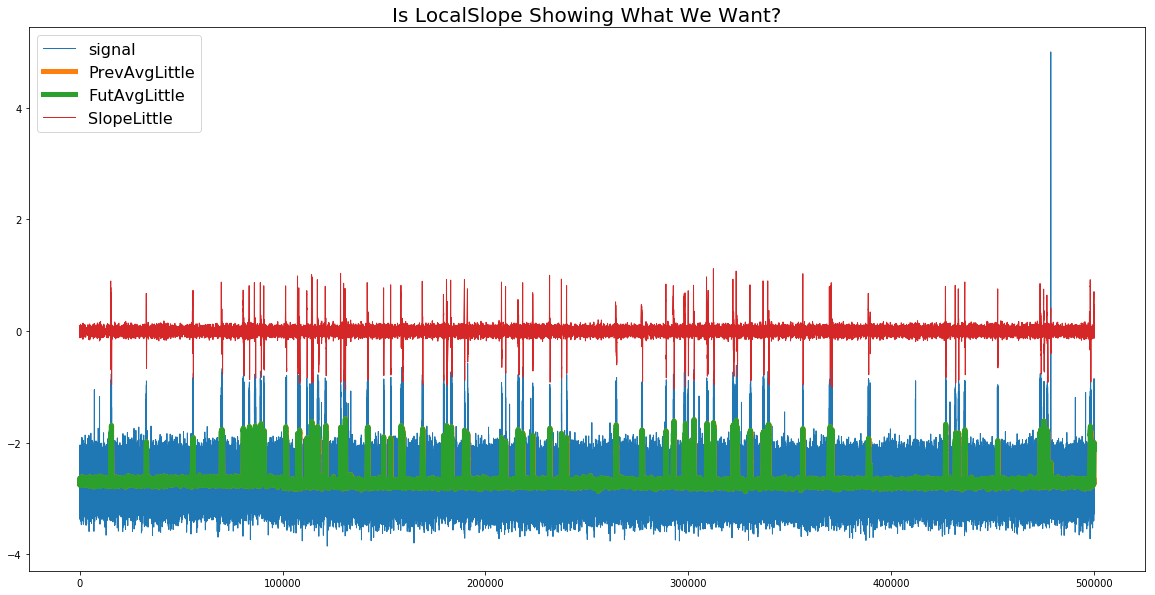

In [211]:
plot_features(['signal', 'PrevAvgLittle', 'FutAvgLittle', 'SlopeLittle'],
                     0, 500000, 'Is LocalSlope Showing What We Want?', [1, 5, 5, 1])

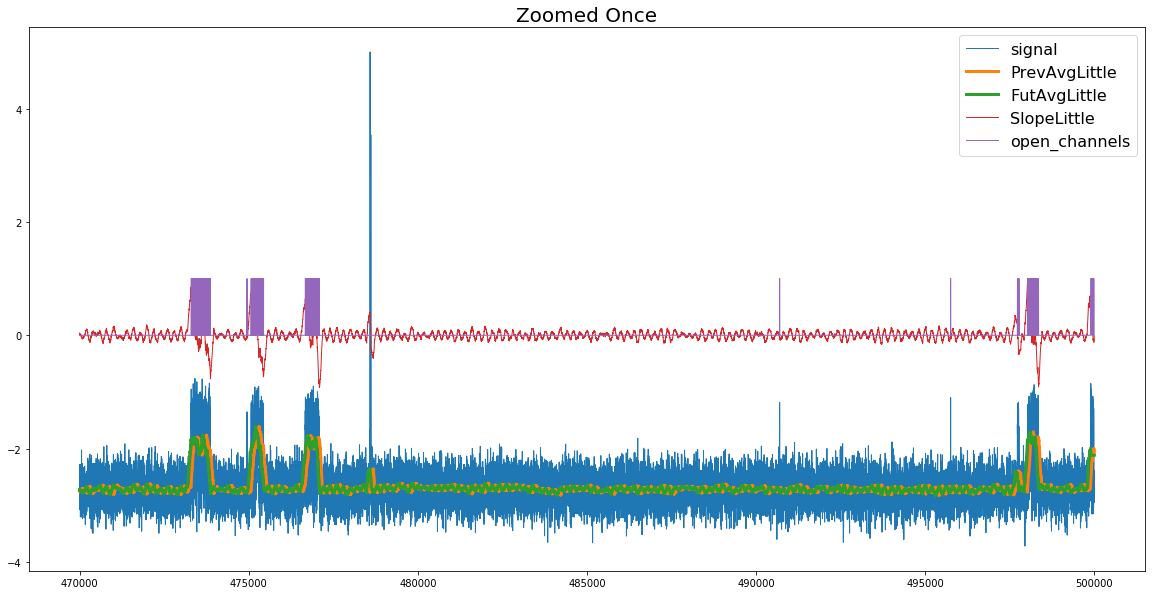

In [212]:
plot_features(['signal', 'PrevAvgLittle', 'FutAvgLittle', 'SlopeLittle', 'open_channels'],
                     470000, 500000, 'Zoomed Once', [1, 3, 3, 1, 1])

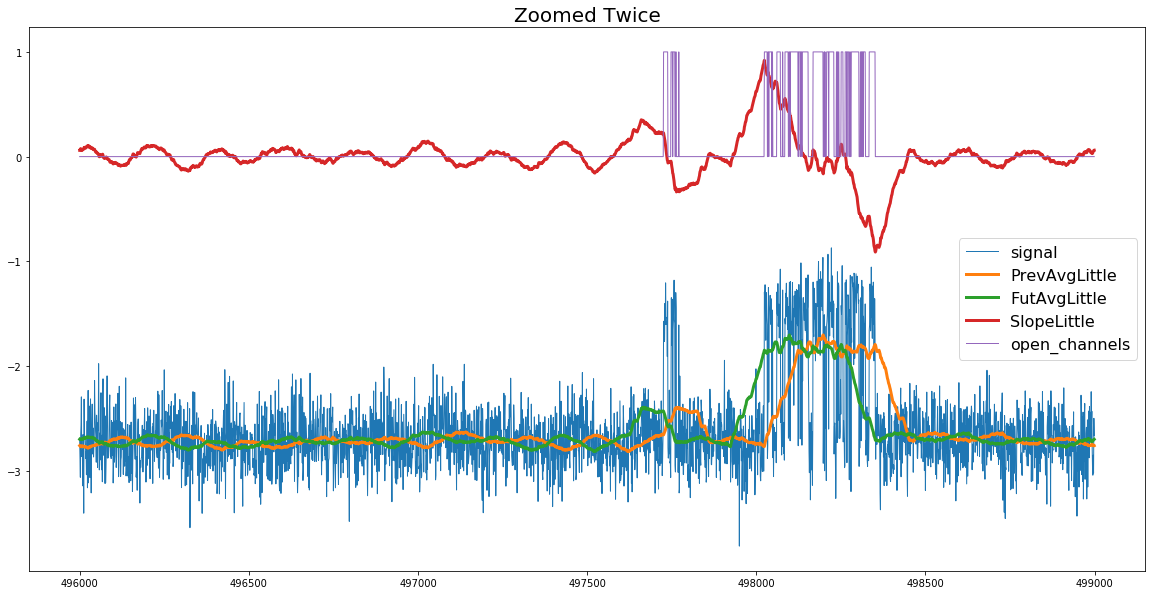

In [213]:
plot_features(['signal', 'PrevAvgLittle', 'FutAvgLittle', 'SlopeLittle', 'open_channels'],
                     496000, 499000, 'Zoomed Twice', [1, 3, 3, 3, 1])

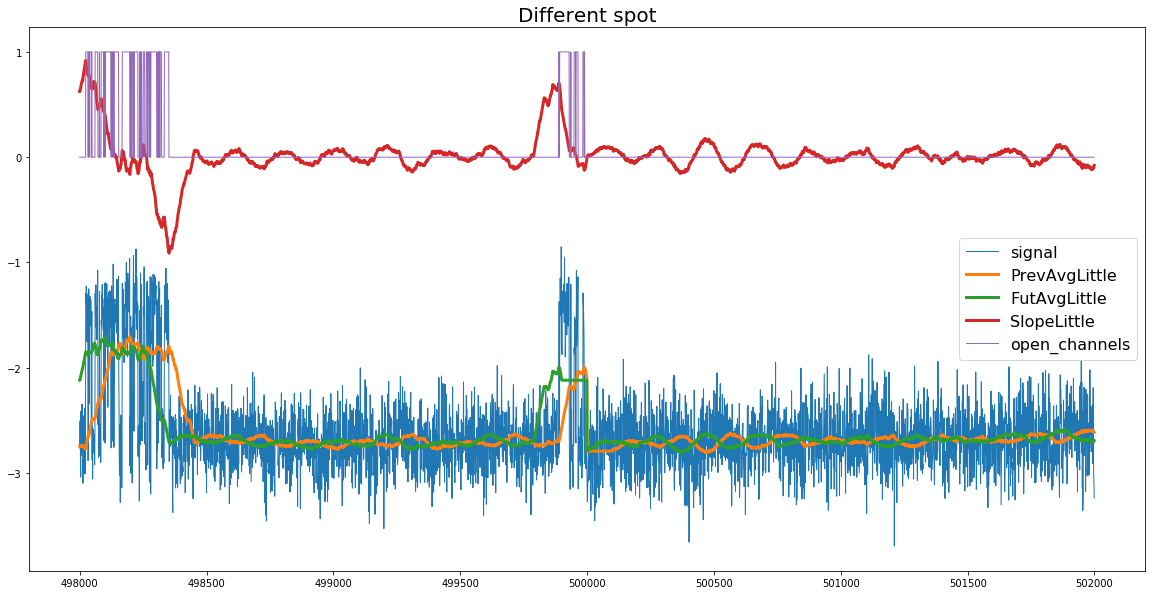

In [214]:
plot_features(['signal', 'PrevAvgLittle', 'FutAvgLittle', 'SlopeLittle', 'open_channels'],
                     498000, 502000, 'Different spot', [1, 3, 3, 3, 1])

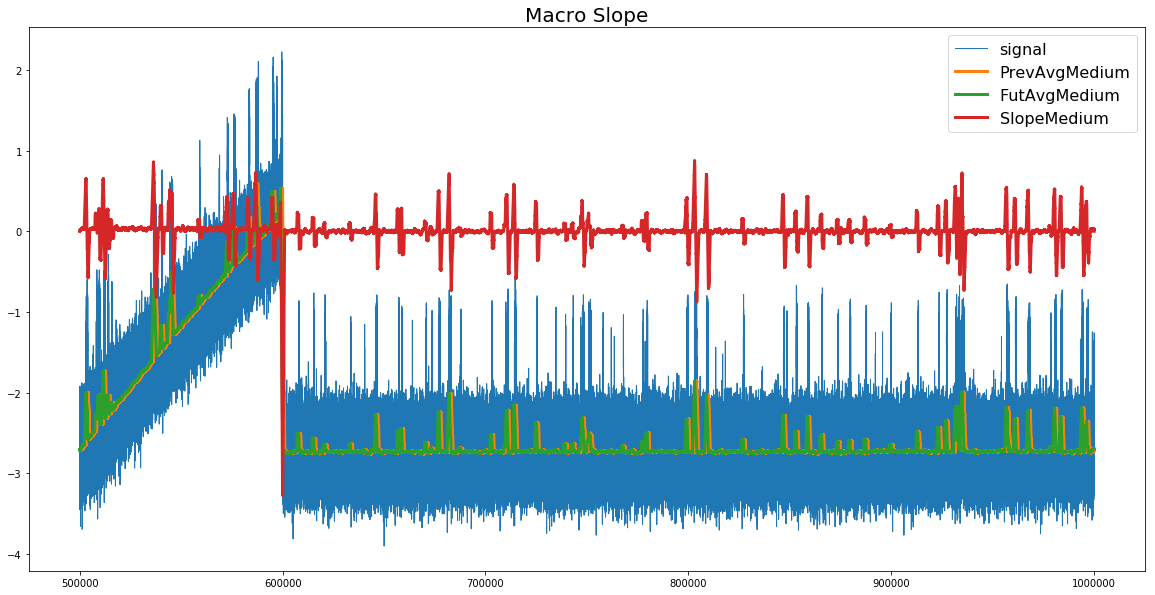

In [215]:
plot_features(['signal', 'PrevAvgMedium', 'FutAvgMedium', 'SlopeMedium'],
                     500000, 1000000, 'Medium Slope', [1, 3, 3, 3])

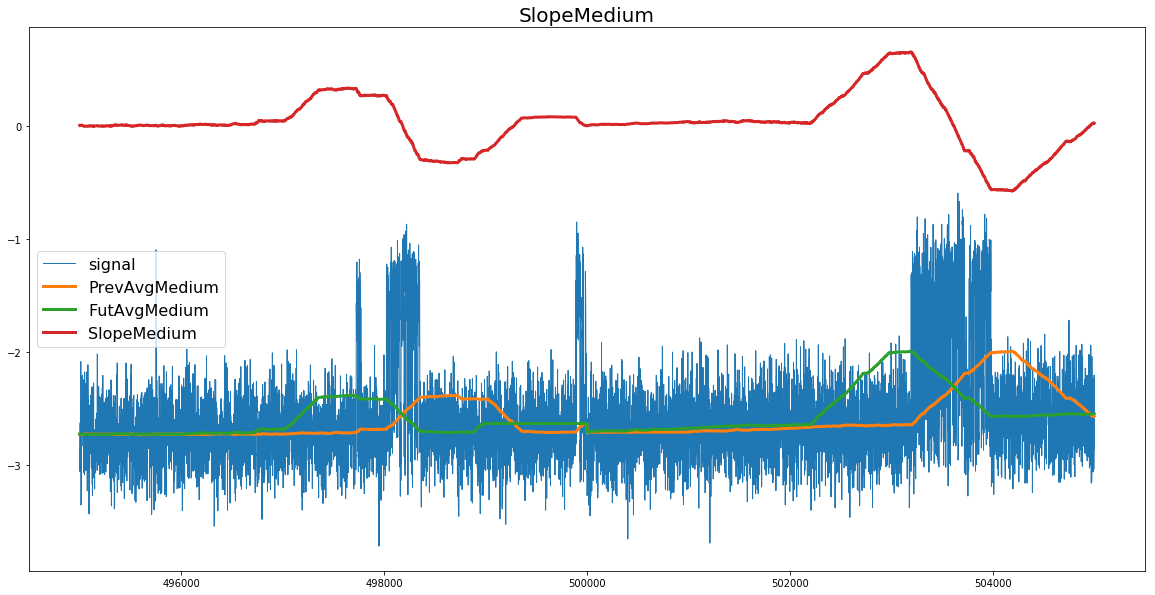

In [218]:
plot_features(['signal', 'PrevAvgMedium', 'FutAvgMedium', 'SlopeMedium'],
                     495000, 505000, 'SlopeMedium', [1, 3, 3, 3])

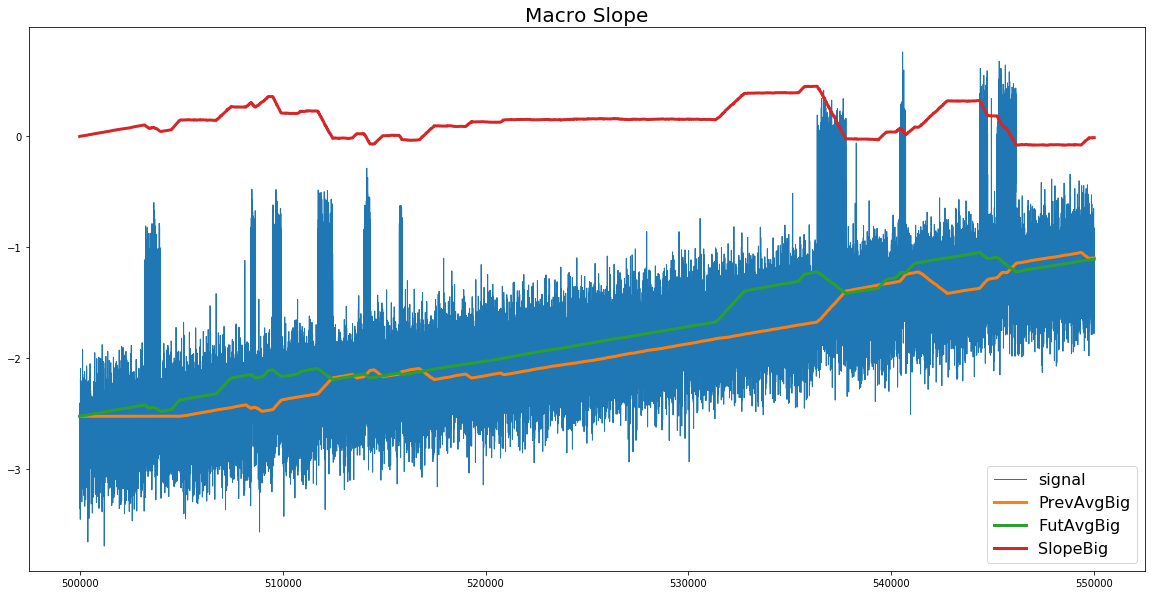

In [217]:
plot_features(['signal', 'PrevAvgBig', 'FutAvgBig', 'SlopeBig'],
                     500000, 550000, 'Macro Slope', [1, 3, 3, 3])

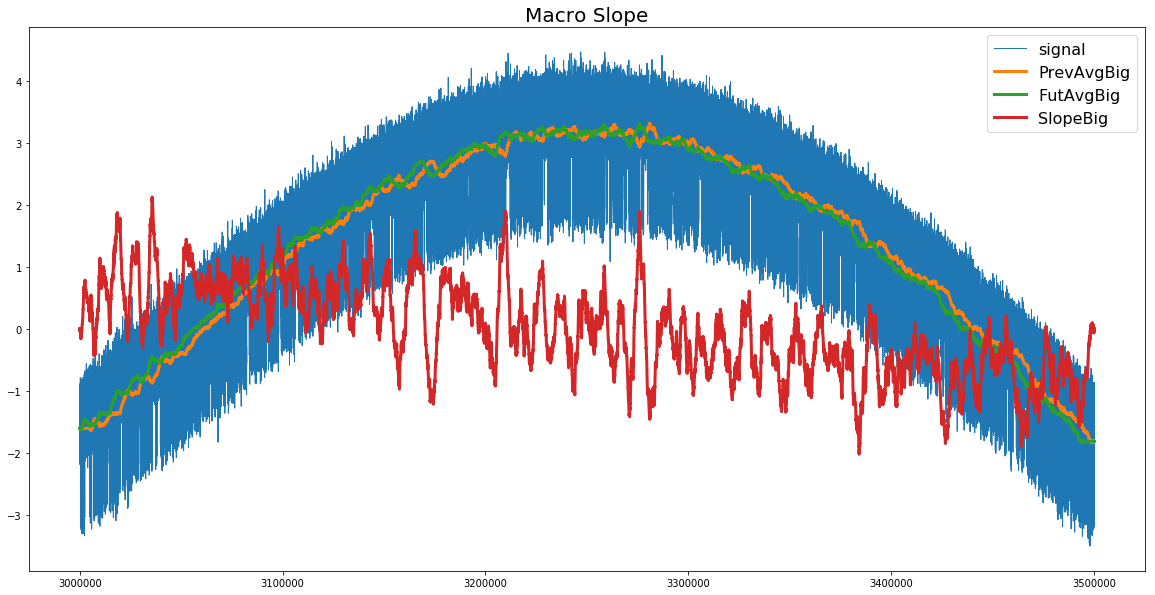

In [223]:
plot_features(['signal', 'PrevAvgBig', 'FutAvgBig', 'SlopeBig'],
                     3000000, 3500000, 'Macro Slope', [1, 3, 3, 3])

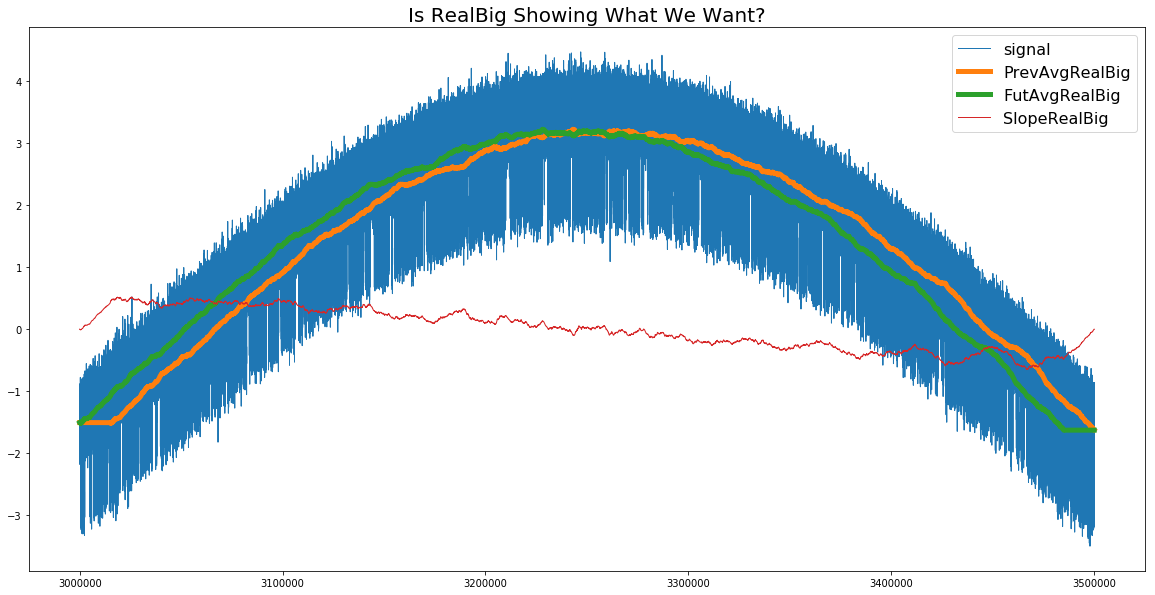

In [226]:
plot_features(['signal', 'PrevAvgRealBig', 'FutAvgRealBig', 'SlopeRealBig'],
                     3000000, 3500000, 'Is RealBig Showing What We Want?', [1, 5, 5, 1])

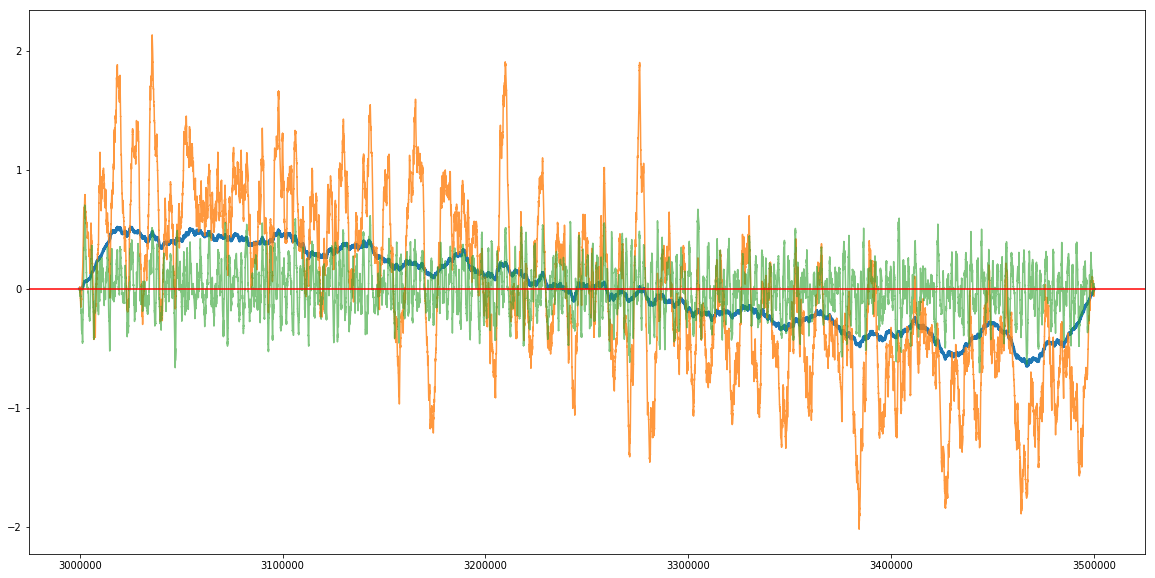

In [232]:
plt.figure(figsize=(20,10))
plt.plot(train_df.SlopeRealBig.iloc[3000000:3500000], lw=3)
plt.plot(train_df.SlopeBig.iloc[3000000:3500000], alpha=.8)
plt.plot(train_df.SlopeMedium.iloc[3000000:3500000], alpha=.6)
plt.axhline(0, color='red')
plt.title('Comparison of Slope Features in Batch 6')
plt.legend(labels=['SlopeRealBig', 'SlopeBig', 'SlopeMedium'])
plt.show()

In [237]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 22 columns):
time              float64
signal            float64
open_channels     int64
batch             int64
previous          float64
second            float64
third             float64
MicroMean         float64
LocalMean         float64
MacroMean         float64
PrevAvgLittle     float64
FutAvgLittle      float64
SlopeLittle       float64
PrevAvgMedium     float64
FutAvgMedium      float64
SlopeMedium       float64
PrevAvgBig        float64
FutAvgBig         float64
SlopeBig          float64
PrevAvgRealBig    float64
FutAvgRealBig     float64
SlopeRealBig      float64
dtypes: float64(20), int64(2)
memory usage: 839.2 MB


In [238]:
train_df.to_csv('/DataScience/liverpool-ion-switching/train_df.csv', index=False)

<h3> Feature Engineering pt. 2 Analysis</h3>

In [2]:
train_df = pd.read_csv('/DataScience/liverpool-ion-switching/train_df.csv')

In [5]:
train_df.columns

Index(['time', 'signal', 'open_channels', 'batch', 'previous', 'second',
       'third', 'MicroMean', 'LocalMean', 'MacroMean', 'PrevAvgLittle',
       'FutAvgLittle', 'SlopeLittle', 'PrevAvgMedium', 'FutAvgMedium',
       'SlopeMedium', 'PrevAvgBig', 'FutAvgBig', 'SlopeBig', 'PrevAvgRealBig',
       'FutAvgRealBig', 'SlopeRealBig'],
      dtype='object')

In [9]:
results = []
for batch in range(10):
    batch_results = []
    rfc = RandomForestClassifier(n_estimators=150, max_depth=5)
    X = train_df.drop(['open_channels', 'time', 'batch'], 1)[train_df.batch == batch]
    Y = train_df['open_channels'][train_df.batch == batch]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
    rfc.fit(X_train, y_train)
    
    for feature in zip(X.columns, rfc.feature_importances_):
        batch_results.append(feature[1])
    
    preds = rfc.predict(X_test)
    batch_results.append(cohen_kappa_score(preds, y_test, weights='quadratic'))
    results.append(batch_results)
    
results_df = pd.DataFrame()
for column in range(len(X.columns)):
    results_df[X.columns[column]] = [item[column] for item in results]

In [10]:
results_df

,signal,previous,second,third,MicroMean,LocalMean,MacroMean,PrevAvgLittle,FutAvgLittle,SlopeLittle,PrevAvgMedium,FutAvgMedium,SlopeMedium,PrevAvgBig,FutAvgBig,SlopeBig,PrevAvgRealBig,FutAvgRealBig,SlopeRealBig
0,0.438936,0.013489,0.029582,0.047235,0.201370,0.034087,0.000876,0.118722,0.092445,0.004527,0.010452,0.005536,0.001467,0.000242,0.000573,0.000149,0.000158,0.000100,0.000053
1,0.217312,0.018193,0.054984,0.095577,0.090446,0.032099,0.080341,0.043419,0.036262,0.009851,0.027849,0.027661,0.002020,0.088482,0.054542,0.000652,0.069168,0.044734,0.006407
2,0.531835,0.027589,0.060449,0.090217,0.205213,0.010962,0.000015,0.035635,0.032936,0.002304,0.001460,0.001087,0.000177,0.000029,0.000044,0.000011,0.000011,0.000018,0.000007
3,0.641856,0.017815,0.039792,0.057649,0.197596,0.007111,0.000180,0.019180,0.016464,0.000655,0.000916,0.000618,0.000022,0.000052,0.000046,0.000012,0.000011,0.000011,0.000013
4,0.722907,0.010936,0.024204,0.046344,0.143003,0.007671,0.000182,0.016841,0.025232,0.000930,0.000589,0.001014,0.000026,0.000032,0.000018,0.000019,0.000021,0.000019,0.000013
5,0.699565,0.015712,0.033869,0.046045,0.162233,0.005356,0.000142,0.015746,0.019287,0.000558,0.000493,0.000789,0.000015,0.000031,0.000098,0.000009,0.000027,0.000022,0.000003
6,0.210361,0.072605,0.179121,0.258944,0.068908,0.007801,0.027501,0.010819,0.011845,0.006679,0.008427,0.008973,0.000030,0.026785,0.036696,0.000021,0.021998,0.042136,0.000350
7,0.403221,0.057400,0.091691,0.135729,0.132298,0.008113,0.028323,0.017699,0.013847,0.000423,0.004441,0.005996,0.000027,0.019531,0.020845,0.000069,0.026358,0.033459,0.000531
8,0.479780,0.035261,0.067774,0.096695,0.103103,0.007245,0.036556,0.011158,0.010498,0.000352,0.014579,0.012110,0.000008,0.027116,0.029476,0.000039,0.034094,0.033817,0.000340
9,0.488719,0.020042,0.044742,0.075429,0.121036,0.008876,0.040334,0.012651,0.012920,0.000092,0.010310,0.010843,0.000114,0.034040,0.034201,0.000050,0.038860,0.046622,0.000118


In [18]:
for column in results_df.columns:
    print(column, results_df[column].sum())

signal 4.83449190661361
previous 0.2890421541474567
second 0.626208225124045
third 0.9498640517238525
MicroMean 1.4252064790999437
LocalMean 0.1293198522323589
MacroMean 0.21444897445493447
PrevAvgLittle 0.3018701153246689
FutAvgLittle 0.2717365850254673
SlopeLittle 0.026371666196745292
PrevAvgMedium 0.07951666708831429
FutAvgMedium 0.07462581648404194
SlopeMedium 0.0039060908150174633
PrevAvgBig 0.1963389052849175
FutAvgBig 0.17654027515797305
SlopeBig 0.0010312648937534322
PrevAvgRealBig 0.19070800681501418
FutAvgRealBig 0.20093792659451065
SlopeRealBig 0.007835036923375288


In [13]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
X = train_df.drop(['open_channels', 'time', 'batch'], 1)
Y = train_df['open_channels']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
print('Results with all features:', cohen_kappa_score(preds, y_test, weights='quadratic'))

Results with all features: 0.8265503448270242


In [14]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
X = train_df[['signal', 'previous', 'second', 'third', 'MicroMean', 'LocalMean', 'MacroMean']]
Y = train_df['open_channels']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
print('Results with original features:', cohen_kappa_score(preds, y_test, weights='quadratic'))

Results with all features: 0.7242890436306675


In [19]:
train_df.drop(['SlopeLittle', 'SlopeMedium', 'SlopeBig', 'SlopeRealBig'], 1, inplace=True)

In [22]:
for i in range(4, 9):
    prev = []
    for batch in train_df.batch.unique():
        prev += list(train_df[train_df.batch == batch].signal.iloc[:i])
        prev += list(train_df[train_df.batch == batch].signal.iloc[:-i])
    train_df['{}_prev'.format(i)] = prev
    train_df['{}_prev'.format(i)] -= train_df.signal

In [24]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
X = train_df.drop(['open_channels', 'time', 'batch'], 1)
Y = train_df['open_channels']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
print('Results with all features:', cohen_kappa_score(preds, y_test, weights='quadratic'))

Results with all features: 0.821494201986834


In [27]:
X = train_df.drop(['open_channels', 'time', 'batch'], 1)
Y = train_df['open_channels']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

dtrain = xgb.DMatrix(X_train)
dtest = xgb.DMatrix(X_test)

classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, 
                  learning_rate=0.07, max_delta_step=0, max_depth=3,
                  min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
                  nthread=None, objective='multi:softmax', num_classes=11, random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                  silent=None, subsample=1, verbosity=1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict_proba(X_test)

hard_max = []
for i in y_pred:
    hard_max.append(np.where(i == np.amax(i))[0][0])
results = cohen_kappa_score(hard_max, y_test, weights='quadratic')
print(results)

0.9017833262008336


To Fix:
1. bigmacroslope fucking up on edges of batches
2. MacroSlope seems meaningless
3. Feature to measure how much average jitter is going on?
4. Need a better method to get the slope in general
5. Feature for average of entire batch